In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib.colors import ListedColormap

2025-05-28 14:12:48.688368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0.5, 1.0, 'Ground Truth')

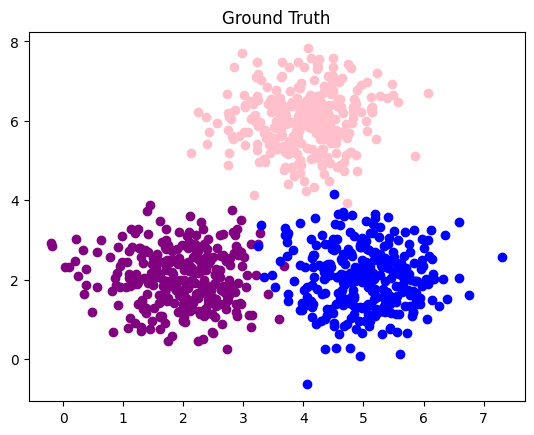

In [2]:
# parameters for Gaussian clusters
cov = [[.5, 0], [0, .5]]  # covariance matrix
mean1 = [2, 2] 
mean2 = [5, 2]
mean3 = [4, 6]
size = 300      # points/cluster

# Generate the data for each cluster
cluster1 = np.random.multivariate_normal(mean1, cov, size)
cluster2 = np.random.multivariate_normal(mean2, cov, size)
cluster3 = np.random.multivariate_normal(mean3, cov, size)
plt.figure()
plt.scatter(cluster1[:,0], cluster1[:,1], color="purple", label="cluster 1")
plt.scatter(cluster2[:,0], cluster2[:,1], color="blue", label="cluster 2")
plt.scatter(cluster3[:,0], cluster3[:,1], color="pink", label="cluster 3")
plt.title("Ground Truth")

In [3]:
#create the model
model = Sequential([
    Dense(8, activation='relu', input_shape=(2,)),
    Dense(3, activation='softmax')  # Output layer for 3-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
#train the model
zeros = np.zeros((cluster1.shape[0], 1))
cluster1wanswer = np.hstack((cluster1, zeros))

ones = np.full((cluster2.shape[0], 1), 1)
cluster2wanswer = np.hstack((cluster2, ones))

twos = np.full((cluster3.shape[0], 1), 2)
cluster3wanswer = np.hstack((cluster3, twos))
everything = np.concatenate((cluster1wanswer, cluster2wanswer, cluster3wanswer))
np.random.shuffle(everything)
X = everything[:, 0:2]
y = everything[:, 2]

model.fit(X, y, epochs=0, batch_size=10)

In [11]:
#print out the weights and accuracy
weights1, biases1 = model.layers[0].get_weights()
print("Weights for first layer:\n", weights1)
print("Biases for first layer:\n", biases1)

weights2, biases2 = model.layers[1].get_weights()
print("Weights for second layer:\n", weights2)
print("Biases for second layer:\n", biases2)

#get accuracy of model
loss, accuracy = model.evaluate(X, y, verbose=0)
print("Accuracy:", accuracy)

Weights for first layer:
 [[ 0.12778315 -0.29323655 -0.35927483 -0.29862967 -0.677685   -0.38171154
   1.2476318  -0.37765792]
 [-0.6346696  -0.2236023   0.42957965 -0.10070985  0.38285676  0.07092672
  -0.49907187  1.6394784 ]]
Biases for first layer:
 [-0.0714075   0.          0.4520954   1.640115   -0.16955438  1.633556
 -0.07162773 -0.9508549 ]
Weights for second layer:
 [[ 0.20364267  0.22092743  0.18655558]
 [-0.3738803  -0.3866934   0.41161138]
 [ 0.27215376 -0.9574893   0.11227112]
 [ 2.7887738  -1.9945015  -1.4822361 ]
 [-0.05227262  0.5385912  -0.07410906]
 [ 2.2777405  -1.1377711  -1.8142735 ]
 [-0.38023123  0.9830992  -0.7314729 ]
 [-0.977683   -0.7655327   0.64972216]]
Biases for second layer:
 [ 0.6504704  -0.27664798 -0.64914423]
Accuracy: 0.9900000095367432


1254/1254 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step


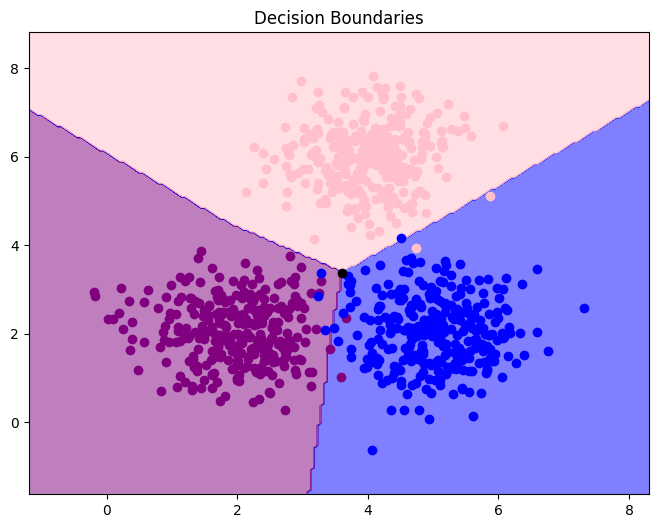

In [12]:
#graphing prediction boundaries and center point

def find_intersection_point(xx, yy, Z):
    rows, cols = Z.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # Grab 3x3 neighborhood
            neighborhood = Z[i-1:i+2, j-1:j+2].flatten()
            unique_classes = np.unique(neighborhood)
            if len(unique_classes) == 3:
                # Found a spot where all 3 classes are neighbors
                x_coord = xx[i, j]
                y_coord = yy[i, j]
                return x_coord, y_coord
    return None, None  # if not found

# Step 1: Create a meshgrid over the input space
h = 0.05  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Step 2: Predict the class for each point in the grid
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid)
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

# Step 3: Plot the decision boundary
custom_cmap = ListedColormap(["purple", "blue", "pink"])
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.5)

# Overlay the original training data
plt.scatter(cluster1[:,0], cluster1[:,1], color="purple", label="cluster 1")
plt.scatter(cluster2[:,0], cluster2[:,1], color="blue", label="cluster 2")
plt.scatter(cluster3[:,0], cluster3[:,1], color="pink", label="cluster 3")
plt.title("Decision Boundaries")

intersect_x, intersect_y = find_intersection_point(xx, yy, Z)
if intersect_x is not None and intersect_y is not None:
    plt.scatter(intersect_x, intersect_y, color="black", label="center of boundaries")
else: print("found no center rip")
plt.show()



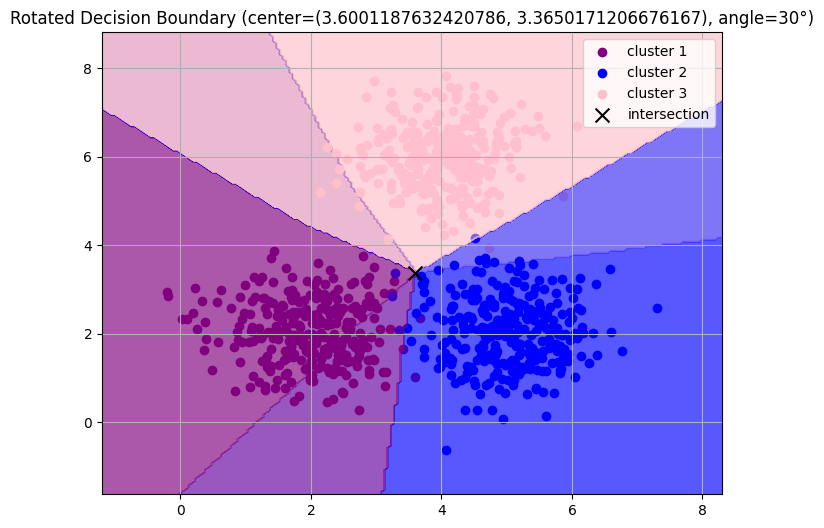

In [16]:
#rotation time! on after thought, probably dont need this.... rotate center instead and create new random values
def rotate_meshgrid(xx, yy, center, angle_degrees):
    angle_rad = np.deg2rad(angle_degrees)

    # Flatten meshgrid for transformation
    x_flat = xx.ravel()
    y_flat = yy.ravel()

    # Shift points to origin based on center
    x_shifted = x_flat - center[0]
    y_shifted = y_flat - center[1]

    # Apply rotation
    x_rot = x_shifted * np.cos(angle_rad) - y_shifted * np.sin(angle_rad)
    y_rot = x_shifted * np.sin(angle_rad) + y_shifted * np.cos(angle_rad)

    # Shift back to original center
    x_new = x_rot + center[0]
    y_new = y_rot + center[1]

    # Reshape back to meshgrid format
    xx_rotated = x_new.reshape(xx.shape)
    yy_rotated = y_new.reshape(yy.shape)

    return xx_rotated, yy_rotated

# Rotate meshgrid around the intersection point
center = (intersect_x, intersect_y)
angle = 30  # degrees

xx_rot, yy_rot = rotate_meshgrid(xx, yy, center, angle)

# Predict on rotated grid
grid_rotated = np.c_[xx_rot.ravel(), yy_rot.ravel()]
Z_rotated = model.predict(grid_rotated, verbose=0)
Z_rotated = np.argmax(Z_rotated, axis=1)
Z_rotated = Z_rotated.reshape(xx.shape)

# Custom color map to match your clusters
cmap = ListedColormap(["purple", "blue", "pink"])

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_rotated, cmap=cmap, alpha=0.3)

# Plot the original data for reference
plt.scatter(cluster1[:,0], cluster1[:,1], color="purple", label="cluster 1")
plt.scatter(cluster2[:,0], cluster2[:,1], color="blue", label="cluster 2")
plt.scatter(cluster3[:,0], cluster3[:,1], color="pink", label="cluster 3")

# Plot the origignal boundaries for reference
plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.5)

# Mark the intersection point
plt.scatter([intersect_x], [intersect_y], color="black", s=100, marker='x', label="intersection")

plt.title(f"Rotated Decision Boundary (center={center}, angle={angle}°)")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3210 - loss: 2.7396
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3816 - loss: 1.0708
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6327 - loss: 0.7917
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6862 - loss: 0.6951
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7845 - loss: 0.5794
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8702 - loss: 0.5023
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9086 - loss: 0.4412
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9274 - loss: 0.3898
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9305 - loss: 0.3442
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9357 - loss: 0.3163
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9265 - loss: 0.2841
Epoch 12/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9505 - lo

Text(0.5, 1.0, 'Ground Truth')

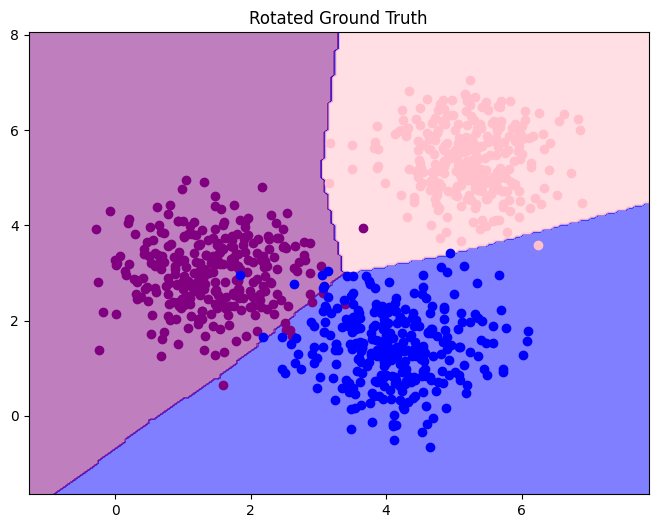

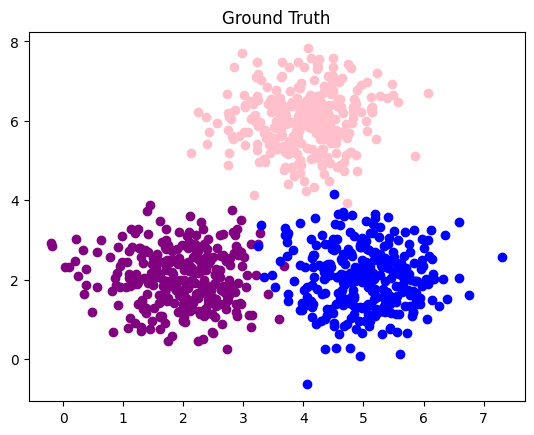

In [25]:
#rotation with new cluster generation

# complete copy and paste from initial generation
# parameters for Gaussian clusters
def rotate_point(x, y, x_center, y_center, angle):
    #rotate anticlockwise
    angle_rad = np.deg2rad(-angle)

    # Shift to origin
    x -= x_center
    y -= y_center

    # Apply rotation
    x_new = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_new = x * np.sin(angle_rad) + y * np.cos(angle_rad)

    # Shift back
    return [x_new + x_center, y_new + y_center]
cov = [[.5, 0], [0, .5]]  # covariance matrix
mean1rotated = rotate_point(mean1[0], mean1[1], intersect_x, intersect_y, angle)
mean2rotated = rotate_point(mean2[0], mean2[1], intersect_x, intersect_y, angle)
mean3rotated = rotate_point(mean3[0], mean3[1], intersect_x, intersect_y, angle)
size = 300      # points/cluster

# Generate the data for each cluster
cluster1rotate = np.random.multivariate_normal(mean1rotated, cov, size)
cluster2rotate = np.random.multivariate_normal(mean2rotated, cov, size)
cluster3rotate = np.random.multivariate_normal(mean3rotated, cov, size)

#create the model
modelrotate = Sequential([
    Dense(8, activation='relu', input_shape=(2,)),
    Dense(3, activation='softmax')  # Output layer for 3-class classification
])

modelrotate.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#train the model
zeros = np.zeros((cluster1rotate.shape[0], 1))
cluster1wanswerrotate = np.hstack((cluster1rotate, zeros))

ones = np.full((cluster2rotate.shape[0], 1), 1)
cluster2wanswerrotate = np.hstack((cluster2rotate, ones))

twos = np.full((cluster3rotate.shape[0], 1), 2)
cluster3wanswerrotate = np.hstack((cluster3rotate, twos))
everythingrotate = np.concatenate((cluster1wanswerrotate, cluster2wanswerrotate, cluster3wanswerrotate))
np.random.shuffle(everythingrotate)
Xrotate = everythingrotate[:, 0:2]
yrotate = everythingrotate[:, 2]

modelrotate.fit(Xrotate, yrotate, epochs=50, batch_size=10)

#get accuracy of model
loss, accuracy = modelrotate.evaluate(Xrotate, yrotate, verbose=0)
print("Accuracy:", accuracy)

#Create decision boundary
# Step 1: Create a meshgrid over the input space
h = 0.05  # step size in the mesh
x_minrotate, x_maxrotate = Xrotate[:, 0].min() - 1, Xrotate[:, 0].max() + 1
y_minrotate, y_maxrotate = Xrotate[:, 1].min() - 1, Xrotate[:, 1].max() + 1
xxrotate, yyrotate = np.meshgrid(np.arange(x_minrotate, x_maxrotate, h),
                     np.arange(y_minrotate, y_maxrotate, h))

# Step 2: Predict the class for each point in the grid
gridrotate = np.c_[xxrotate.ravel(), yyrotate.ravel()]
Zrotate = modelrotate.predict(gridrotate)
Zrotate = np.argmax(Zrotate, axis=1)
Zrotate = Zrotate.reshape(xxrotate.shape)

# Step 3: Plot the decision boundary
custom_cmap = ListedColormap(["purple", "blue", "pink"])
plt.figure(figsize=(8, 6))
plt.contourf(xxrotate, yyrotate, Zrotate, cmap=custom_cmap, alpha=0.5)

plt.scatter(cluster1rotate[:,0], cluster1rotate[:,1], color="purple", label="cluster 1 rotated")
plt.scatter(cluster2rotate[:,0], cluster2rotate[:,1], color="blue", label="cluster 2 rotated")
plt.scatter(cluster3rotate[:,0], cluster3rotate[:,1], color="pink", label="cluster 3 rotated")
plt.title("Rotated Ground Truth")

plt.figure()
plt.scatter(cluster1[:,0], cluster1[:,1], color="purple", label="cluster 1")
plt.scatter(cluster2[:,0], cluster2[:,1], color="blue", label="cluster 2")
plt.scatter(cluster3[:,0], cluster3[:,1], color="pink", label="cluster 3")
plt.title("Ground Truth")

In [ ]:
#TODO: delete one that rotates boundary